In [1]:
import torch
import torch.nn as nn

In [2]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=stride, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(2e-1),
        )
        
    def forward(self, x):
        return self.conv(x)
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(2e-1),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels=in_channels, out_channels=feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels=feature
            
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'),
        )
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1) # concatenating along the channels
        x = self.initial(x)
        x = self.model(x)
        return x

In [3]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, padding_mode='reflect', bias=False)
            if down
            else nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU() if act == 'relu' else nn.LeakyReLU(2e-1),
        )
        
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(5e-1)
        
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x
    
    
# this will be a u-net type model
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(2e-1),
        ) # 128
        self.down1 = Block(in_channels=features, out_channels=features*2, down=True, act='leaky', use_dropout=False) # 64
        self.down2 = Block(in_channels=features*2, out_channels=features*4, down=True, act='leaky', use_dropout=False) # 32
        self.down3 = Block(in_channels=features*4, out_channels=features*8, down=True, act='leaky', use_dropout=False) # 16
        self.down4 = Block(in_channels=features*8, out_channels=features*8, down=True, act='leaky', use_dropout=False) # 8
        self.down5 = Block(in_channels=features*8, out_channels=features*8, down=True, act='leaky', use_dropout=False) # 4
        self.down6 = Block(in_channels=features*8, out_channels=features*8, down=True, act='leaky', use_dropout=False) # 2
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=features*8, out_channels=features*8, kernel_size=4, stride=2, padding=1, padding_mode='reflect'), # 1x1
            nn.ReLU()
        )
        
        self.up1 = Block(in_channels=features*8, out_channels=features*8, down=False, act='relu', use_dropout=True)
        self.up2 = Block(in_channels=features*8*2, out_channels=features*8, down=False, act='relu', use_dropout=True)
        self.up3 = Block(in_channels=features*8*2, out_channels=features*8, down=False, act='relu', use_dropout=True)
        self.up4 = Block(in_channels=features*8*2, out_channels=features*8, down=False, act='relu', use_dropout=False)
        self.up5 = Block(in_channels=features*8*2, out_channels=features*4, down=False, act='relu', use_dropout=False)
        self.up6 = Block(in_channels=features*4*2, out_channels=features*2, down=False, act='relu', use_dropout=False)
        self.up7 = Block(in_channels=features*2*2, out_channels=features, down=False, act='relu', use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(in_channels=features*2, out_channels=in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        ) # returning the logits, and using Tanh as we had normalized the image to [-1, 1]
        
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        
        bottleneck = self.bottleneck(d7)
        
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], dim=1))
        up3 = self.up3(torch.cat([up2, d6], dim=1))
        up4 = self.up4(torch.cat([up3, d5], dim=1))
        up5 = self.up5(torch.cat([up4, d4], dim=1))
        up6 = self.up6(torch.cat([up5, d3], dim=1))
        up7 = self.up7(torch.cat([up6, d2], dim=1))
        up8 = self.final_up(torch.cat([up7, d1], dim=1))
        
        return up8

In [4]:
import os
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# clear the GPUs
torch.cuda.empty_cache()

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()
HEIGHT = 256
WIDTH = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
NUM_EPOCHS = 400

In [6]:
both_transform = A.Compose(
    [A.Resize(width=WIDTH, height=HEIGHT), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),],
    additional_targets={'image0': 'image'},
)

In [7]:
transform_only_inp = A.Compose(
    [A.ColorJitter(p=0.1), A.Normalize(mean=[5e-1, 5e-1, 5e-1], std=[5e-1, 5e-1, 5e-1], max_pixel_value=255.0), ToTensorV2(),]
)

In [8]:
transform_only_tar = A.Compose(
    [A.Normalize(mean=[5e-1, 5e-1, 5e-1], std=[5e-1, 5e-1, 5e-1], max_pixel_value=255.0), ToTensorV2(),]
)

In [9]:
from PIL import Image
import numpy as np
import os

from torch.utils.data import Dataset

In [10]:
# https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset
class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        
    def __len__(self):
        return len(self.list_files)
    
    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        
        img = np.array(Image.open(img_path))
        
        # image size is 600x600
        inp_img = img[:, :600, :] # take all the channels, width, height
        tar_img = img[:, 600:, :]
        
        augmentation = both_transform(image=inp_img, image0=tar_img)
        inp_img, tar_img = augmentation['image'], augmentation['image0']
        
        inp_img = transform_only_inp(image=inp_img)['image']
        tar_img = transform_only_tar(image=tar_img)['image']
        
        return inp_img, tar_img

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from torchvision.utils import make_grid, save_image

In [12]:
disc = Discriminator(in_channels=3, features=[64, 128, 256, 512]).to(DEVICE)
gen = Generator(in_channels=3, features=64).to(DEVICE)

opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(5e-1, 999e-3))
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(5e-1, 999e-3))

BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

'''
    Automatic Mixed Precision package - torch.amp

    torch.amp provides convenience methods for mixed precision,
    where some operations use the torch.float32 (float) datatype
    and other operations use lower precision floating point
    datatype (lower_precision_fp): torch.float16 (half) or torch.bfloat16.
    Some ops, like linear layers and convolutions, are much faster in lower_precision_fp. 
    Other ops, like reductions, often require the dynamic range of float32. 
    Mixed precision tries to match each op to its appropriate datatype.
'''

d_scaler = torch.cuda.amp.GradScaler() # float 16 training, to save VRAM
g_scaler = torch.cuda.amp.GradScaler()

In [13]:
train_dataset = MapDataset(root_dir='/kaggle/input/pix2pix-dataset/maps/maps/train')
val_dataset = MapDataset(root_dir='/kaggle/input/pix2pix-dataset/maps/maps/val')

(-0.5, 1291.5, 259.5, -0.5)

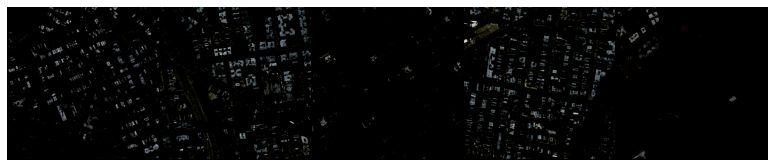

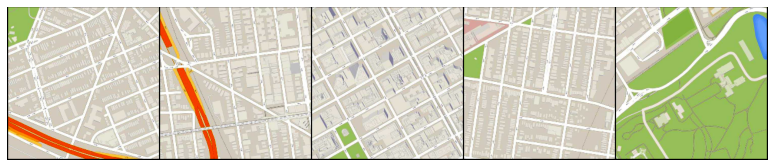

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set()

# Get the first 10 training examples and their labels
images, labels = zip(*[train_dataset[i] for i in range(5)])

# Convert the images to a tensor
images = torch.stack(images)
labels = torch.stack(labels)

# Use make_grid to create a grid of images
grid_img = make_grid(images, nrow=5, )
grid_lab = make_grid(labels, nrow=5, )

# Convert the grid to a NumPy array and plot it
fig, ax = plt.subplots(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.imshow(grid_img.numpy().transpose((1, 2, 0)))
plt.axis('off')

# plt.figure() # calling figure to create new figure
fig, ax = plt.subplots(figsize=(30, 10))
plt.subplot(1, 2, 2)
plt.imshow(grid_lab.numpy().transpose((1, 2, 0)))
plt.axis('off')

In [15]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [16]:
%%timeit -r 1 -n 1
for epoch in tqdm(range(1, NUM_EPOCHS + 1), leave=True, desc='Epoch: '):
    loss_d = loss_g = 0
#     progress = tqdm(enumerate(train_loader), leave=False, total=len(train_loader), desc='Batch: ')
    for idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            d_real = disc(x, y)
            d_fake = disc(x, y_fake.detach())
            
            d_real_loss = BCE(d_real, torch.ones_like(d_real))
            d_fake_loss = BCE(d_fake, torch.zeros_like(d_fake))
            
            d_loss = (d_real_loss + d_fake_loss) / 2
         
        loss_d += d_loss
        
        disc.zero_grad()
        d_scaler.scale(d_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        with torch.cuda.amp.autocast():
            d_fake = disc(x, y_fake)
            
            g_fake_loss = BCE(d_fake, torch.ones_like(d_fake))
            l1 = L1_LOSS(y_fake, y) * L1_LAMBDA
            
            g_loss = g_fake_loss + l1
            
        loss_g += g_loss
        
        gen.zero_grad()
        g_scaler.scale(g_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
    if not (epoch % 40):
        print(f'Epoch: [{epoch}/{NUM_EPOCHS}] | LossD: {loss_d:.4f} | LossG: {loss_g:.4f}')

Epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch: [40/400] | LossD: 7.8853 | LossG: 189.5642
Epoch: [80/400] | LossD: 6.0316 | LossG: 196.2602
Epoch: [120/400] | LossD: 6.0604 | LossG: 178.0777
Epoch: [160/400] | LossD: 2.6375 | LossG: 192.9698
Epoch: [200/400] | LossD: 0.7745 | LossG: 208.6060
Epoch: [240/400] | LossD: 8.2451 | LossG: 165.3886
Epoch: [280/400] | LossD: 8.9093 | LossG: 158.2145
Epoch: [320/400] | LossD: 2.8054 | LossG: 180.2563
Epoch: [360/400] | LossD: 1.5809 | LossG: 208.7023
Epoch: [400/400] | LossD: 1.4443 | LossG: 193.7122
2h 19min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


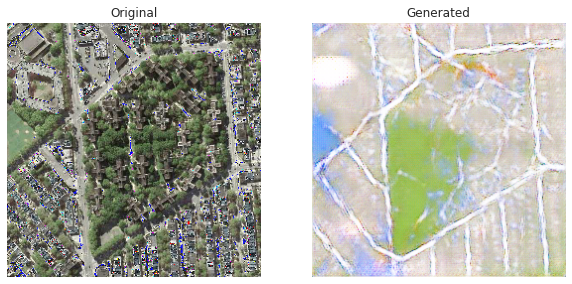

In [17]:
import torchvision.transforms as transforms

fig, ax = plt.subplots(figsize=(10, 10))

val_iter = iter(val_loader)
images, _ = next(val_iter)

rand_im = torch.randint(low=0, high=BATCH_SIZE, size=(1,)).item()

img = images[rand_im]

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(transforms.ToPILImage()(img))

# Generated

img = img.unsqueeze(dim=0).to(DEVICE) # unsqueeze because we have passed a batch of inputs to trained model

gen_img = gen(img)
gen_img = gen_img.squeeze()

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Generated")
plt.imshow(transforms.ToPILImage()(gen_img))

In [18]:
x, tar = zip(*[val_dataset[i] for i in range(20)])

x = torch.stack(x)
tar = torch.stack(tar)

(-0.5, 1291.5, 1033.5, -0.5)

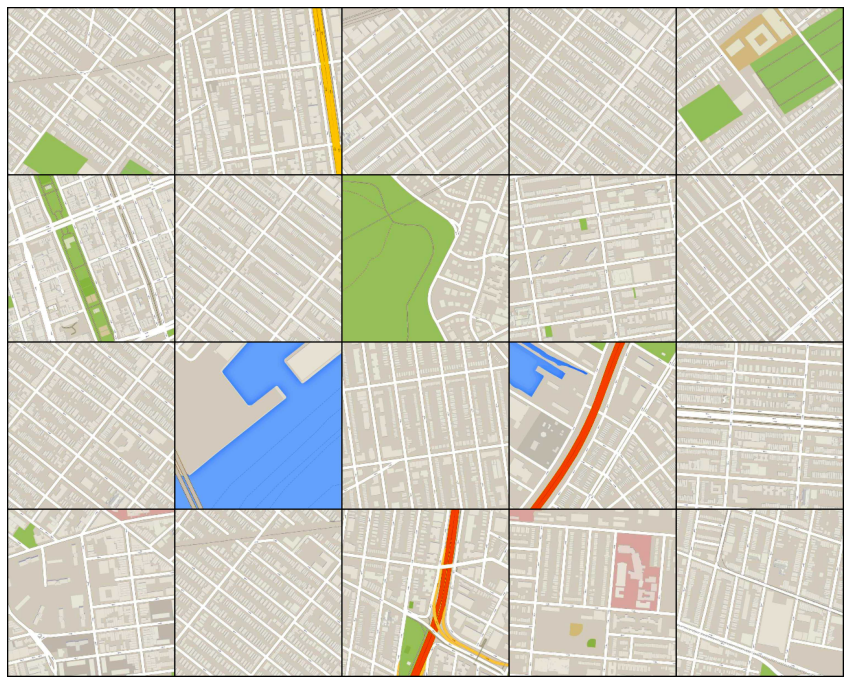

In [19]:
grid_tar = make_grid(tar, nrow=5, )

# plt.figure() # calling figure to create new figure
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(grid_tar.numpy().transpose((1, 2, 0)))
plt.axis('off')

(-0.5, 1291.5, 1033.5, -0.5)

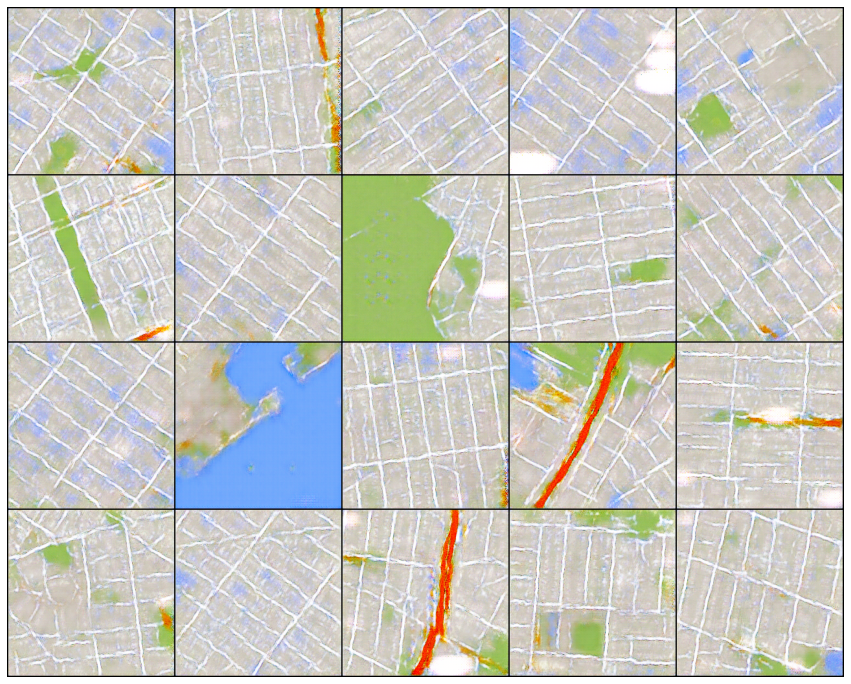

In [20]:
x = gen(x.to(DEVICE))
grid_x = make_grid(x, nrow=5, )

# plt.figure() # calling figure to create new figure
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(grid_x.cpu().numpy().transpose((1, 2, 0)))
plt.axis('off')